In [275]:
from plantcv import plantcv as pcv
# import analyze_area
import cv2
from matplotlib import pyplot as plt
import numpy as np
import cluster_jordan
import math

# set to "plot" to see image at every step (takes longer)
class options:
    def __init__(self):
        self.image = "./img/original_image.jpg"
        self.debug = "plot"
        self.writeimg= False
        self.result = "vis_tutorial_results.json"
        self.outdir = "." # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter
pcv.params.debug = args.debug

In [276]:
imagelink = f"./ELA_Test.jpg"
image = cv2.imread(imagelink)
shape = np.shape(image)

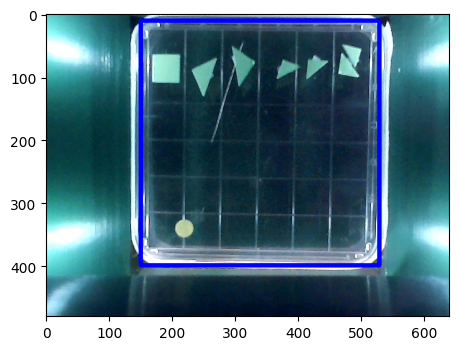

In [277]:
img = pcv.crop(img = image, x = 150, y = 10, h = 390, w = 380)

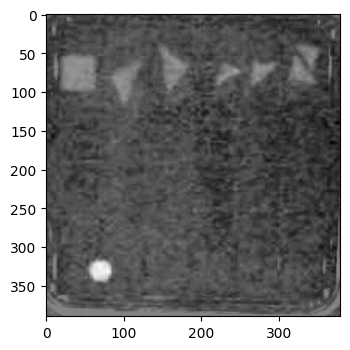

72.802004048583


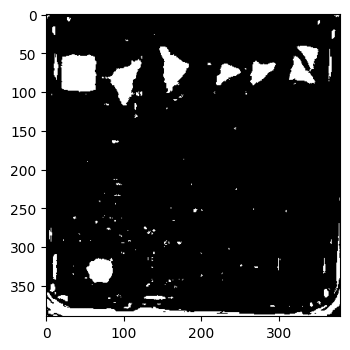

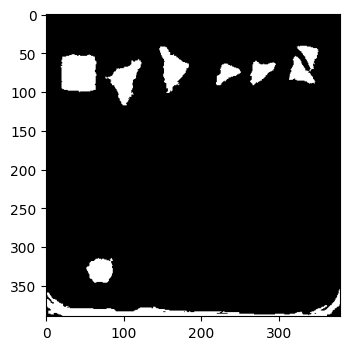

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/morphology/misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_closing`. It will be removed in version 1.0.Please use `footprint` instead.


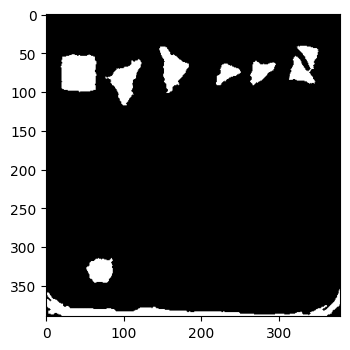

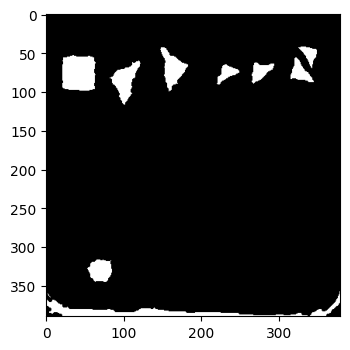

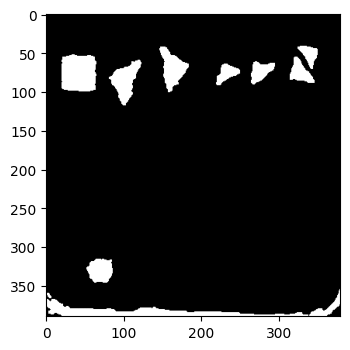

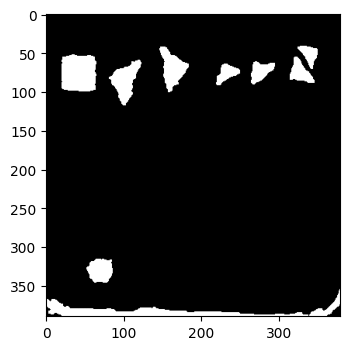

In [278]:

b = pcv.rgb2gray_lab(rgb_img=img, channel="b")
avg = np.average(img)
print(avg)
std = np.std(img)
if avg > 220 and std < 25:
    b = pcv.hist_equalization(b)
    t = 100
else:
    t = 128
b_thresh = pcv.threshold.binary(gray_img=b, threshold= t-6, max_value=255, object_type="light")
bsa_fill1 = pcv.fill(bin_img=b_thresh, size=300)
bsa_fill1 = pcv.closing(gray_img=bsa_fill1)
bsa_fill1 = pcv.erode(gray_img = bsa_fill1, ksize = 3, i = 1)
bsa_fill1 = pcv.dilate(gray_img=bsa_fill1, ksize = 3, i = 1)
bsa_fill1 = pcv.fill(bin_img=bsa_fill1, size=300)


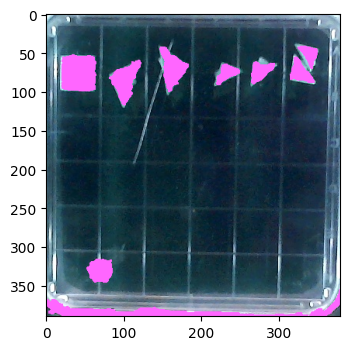

In [279]:
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=bsa_fill1)

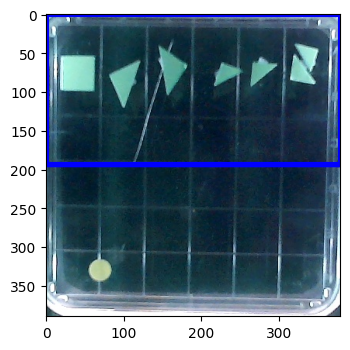

In [280]:
shape = np.shape(img)
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img, x=0, y=0, h=shape[0]/2, w=shape[1])

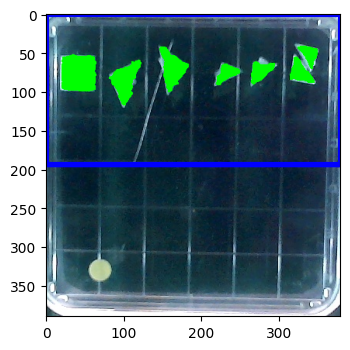

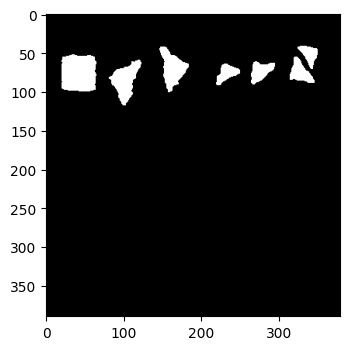

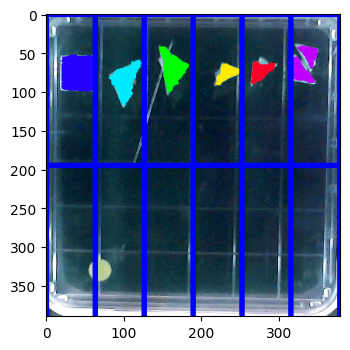

<class 'list'> <class 'tuple'> <class 'numpy.ndarray'>
testing here


AttributeError: 'numpy.ndarray' object has no attribute 'show'

In [281]:
# gives 4 diff outputs
# list of objs, hierarchies say object or hole w/i object
roi_objects, hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img,
                                                              roi_contour=roi_contour, roi_hierarchy=roi_hierarchy,
                                                              object_contour=id_objects, obj_hierarchy=obj_hierarchy, roi_type="partial")

# clustering defined leaves into individual plants using predefined rows/cols
clusters_i, contours, hierarchies = cluster_jordan.cluster_contours(img=img, roi_objects=roi_objects,
                                                         roi_obj_hierarchy=hierarchy, nrow=2, ncol=6, show_grid=True)
print(type(clusters_i), type(contours), type(hierarchies))
print("testing here")
hierarchies.show()
print("testing done")
# split the clusters into individual images for analysis
output_path, imgs, masks = cluster_jordan.cluster_contour_splitimg(rgb_img=img,
                                                        grouped_contour_indexes=clusters_i, contours=contours,
                                                        hierarchy=hierarchies)

In [ ]:
sus = False
num_plants = 0
areas = {}

for i in range(0,6):
    pos = 7-(i+1)
    if clusters_i[i][0] != None:
        id_objects, obj_hierarchy = pcv.find_objects(img=imgs[num_plants], mask=masks[num_plants])
        obj, mask1 = pcv.object_composition(img=imgs[num_plants], contours=id_objects, hierarchy=obj_hierarchy)
        m = cv2.moments(obj)
        area = m['m00']
        num_plants += 1
        center, expect_r = cv2.minEnclosingCircle(obj)
        r = math.sqrt(area/math.pi)
        leaf_error = False
        if r <= 0.35*expect_r:
            leaf_error = True
            sus = True
            print(f"warning: there may be an error detecting leaf {pos}")

        areas[pos] = area
    else:
        areas[pos] = 0
print(areas)

In [ ]:
scale_crop = img
shape = np.shape(scale_crop)
print(shape)
print(scale_crop.shape)
roi_contour_scale, roi_hierarchy_scale = pcv.roi.rectangle(img=scale_crop, x=0, y=shape[0]/2, h=shape[0]/2, w=shape[0]/2)
#roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img, x=0, y=0, h=shape[0]/2, w=shape[1])

In [ ]:
roi_scale, scale_hierarchy, scale_mask, scale_area = pcv.roi_objects(img=scale_crop,
                                                              roi_contour=roi_contour_scale, roi_hierarchy=roi_hierarchy_scale,
                                                                     object_contour=id_scale, obj_hierarchy=obj_hierarchy, roi_type="partial")
count = 0
for object in roi_scale:
    m = cv2.moments(object)
    area = m['m00']
    (x,y), expect_r = cv2.minEnclosingCircle(object)
    r = math.sqrt(area/math.pi)
    print(area)
    scale_pixels = area
    if r >= 0.85*expect_r and area > 100:
        id_scale = object
        hier = scale_hierarchy[0][count]
        scale_pixels = area
        print(area)
        break
    count += 1
scale_area = 100  # mm2
pixels_per_mm2 = float(scale_pixels)/scale_area
print(pixels_per_mm2)

In [ ]:
print(areas)
converted_areas = {}
for pos, area in areas.items():
    converted_areas[pos] = area/pixels_per_mm2

print(converted_areas)